In [1]:
import argparse
from datetime import datetime
import os
import json
import pandas as pd
import time
import matplotlib.pyplot as plt

import numpy as np
from transformers import GPT2LMHeadModel,AdamW, WarmupLinearSchedule
from torch.utils.tensorboard import SummaryWriter
import torch
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from tqdm import tnrange, tqdm_notebook

from dataset import GPT21024Dataset 
from utils import add_special_tokens, generate_sample, set_seed

In [2]:
filename = "pubmed_gene_go_summary.tsv"
path = os.path.join("pubmed", filename)
pubmed_table = pd.read_csv(path, sep = "\t")
pubmed_table = pubmed_table[pubmed_table['Abstract'].notna()]
pubmed_table = pubmed_table[pubmed_table['Target'].notna()]
pubmed_table.shape

(7652, 5)

In [3]:
pubmed_table.head(5)

,GeneID,PubMed,Target,Title,Abstract
0,12,14668352,SERPINA3 enables DNA binding; located_in nucleus.,The SANT2 domain of the murine tumor cell DnaJ...,The murine tumor cell DnaJ-like protein 1 or M...
1,64215,14668352,DNAJC1 enables ATPase activator activity; invo...,The SANT2 domain of the murine tumor cell DnaJ...,The murine tumor cell DnaJ-like protein 1 or M...
2,12,2404007,SERPINA3 enables serine-type endopeptidase inh...,"Cloning, expression, purification, and biologi...",Human alpha 1-antichymotrypsin has been cloned...
3,13,11481320,AADAC enables lipase activity.,Characterization of the rodent genes for aryla...,"In the current study, we have determined the c..."
4,13,8063807,AADAC enables catalytic activity.,Human liver arylacetamide deacetylase. Molecul...,Microsomal arylacetamide deacetylase (DAC) com...


In [4]:
def write_json(i, article, abstract):
    """ Saves a json file."""

    file = "./pubmed/gpt2_1024_data/"+str(i)+".json"
    js_example = {}
    js_example['id'] = i
    js_example['article'] = article
    js_example['abstract'] = abstract
    with open(file, 'w') as f:
        json.dump(js_example, f, ensure_ascii=False)

In [5]:
tokenizer = add_special_tokens()
train_ids = []
#file_id_map = {}
sizes = []
for index, row in pubmed_table.iterrows():
    article = row["Abstract"]
    summary = row["Title"] + row["Target"]
    article = tokenizer.encode(article)
    summary = tokenizer.encode(summary)
    sizes.append(len(article) + len(summary))
    if len(article) > 0 and len(summary) > 0 and (len(article) + len(summary) <= 1023):
        train_ids.append(index)
        write_json(index, article, summary)
        #file_id_map[i] = os.path.basename(file).replace('.story', '')
        if index%100==0:
            print(index, " files written")
            
x,y = int(len(train_ids)*0.8), int(len(train_ids)*0.9)
valid_ids = train_ids[x:y]
test_ids = train_ids[y:]
train_ids = train_ids[:x]
with open("./pubmed/ids.json",'w') as f:
    js = {}
    js['train_ids'] = train_ids
    js['valid_ids'] = valid_ids
    js['test_ids'] = test_ids
    json.dump(js,f)


0  files written
100  files written
200  files written
300  files written
400  files written
500  files written
600  files written
700  files written
800  files written
900  files written
1000  files written
1100  files written
1200  files written
1400  files written
1500  files written
1600  files written
1700  files written
1800  files written
1900  files written
2000  files written
2100  files written
2200  files written
2300  files written
2400  files written
2500  files written
2600  files written
2700  files written
2800  files written
2900  files written
3000  files written
3100  files written
3200  files written
3300  files written
3400  files written
3500  files written
3600  files written
3700  files written
3800  files written
3900  files written
4000  files written
4100  files written
4200  files written
4300  files written
4400  files written
4500  files written
4600  files written
4700  files written
4800  files written
4900  files written
5000  files written
5100  files 

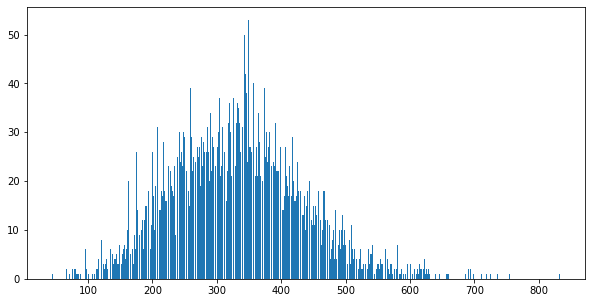

In [6]:
fig = plt.figure(figsize = (10, 5))

keys, counts = np.unique(sizes, return_counts=True)

plt.bar(keys, counts)
plt.show()

In [13]:
#please change default arguments if needed

parser = argparse.ArgumentParser()
parser.add_argument("--lr",default=5e-5, type=float, help="learning rate")
parser.add_argument("--seed",default=42, type=int,  help="seed to replicate results")
parser.add_argument("--n_gpu",default=1, type=int,  help="no of gpu available")
parser.add_argument("--gradient_accumulation_steps",default=32, type=int, help="gradient_accumulation_steps")
parser.add_argument("--batch_size",default=1, type=int,  help="batch_size")
parser.add_argument("--num_workers",default=4, type=int,  help="num of cpus available")
parser.add_argument("--device",default=torch.device('cuda'), help="torch.device object")
parser.add_argument("--num_train_epochs",default=5, type=int,  help="no of epochs of training")
parser.add_argument("--output_dir",default='./output', type=str,  help="path to save evaluation results")
parser.add_argument("--model_dir",default='./weights', type=str,  help="path to save trained model")
parser.add_argument("--max_grad_norm",default=1.0, type=float, help="max gradient norm.")
parser.add_argument("--root_dir",default='./pubmed/gpt2_1024_data', type=str, help="location of json dataset.")
parser.add_argument("--ids_file",default='./pubmed/ids.json', type=str, help="location of train, valid and test file indexes")
args = parser.parse_args([])
print(args)

Namespace(lr=5e-05, seed=42, n_gpu=1, gradient_accumulation_steps=32, batch_size=1, num_workers=4, device=device(type='cuda'), num_train_epochs=5, output_dir='./output', model_dir='./weights', max_grad_norm=1.0, root_dir='./pubmed/gpt2_1024_data', ids_file='./pubmed/ids.json')


In [14]:
def train(args, model, tokenizer, train_dataset, valid_dataset, ignore_index):
    """ Trains GPT2 model and logs necessary details.
        Args:
            args: dict that contains all the necessary information passed by user while training
            model: finetuned gpt/gpt2 model
            tokenizer: GPT/GPT2 tokenizer
            train_dataset: GPT21024Dataset object for training data
            ignore_index: token not considered in loss calculation
    """
    writer = SummaryWriter('./output/logs')
    train_sampler = RandomSampler(train_dataset)
    train_dl = DataLoader(train_dataset,sampler=train_sampler,batch_size=args.batch_size,num_workers=args.num_workers)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index) #ignores padding token for loss calculation
    optimizer = AdamW(model.parameters(),lr=args.lr)
    scheduler = WarmupLinearSchedule(optimizer,200,80000)
    loss_trace = []

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = tnrange(int(args.num_train_epochs), desc="Epoch")
    set_seed(args)
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dl, desc="Training")
        for step, batch in enumerate(epoch_iterator):
            inputs, labels = batch['article'].to(args.device), batch['article'].to(args.device)
            model.train()
            logits = model(inputs)[0]
            # only consider loss on reference summary just like seq2seq models
            shift_logits = logits[..., batch['sum_idx']:-1, :].contiguous()
            shift_labels = labels[..., batch['sum_idx']+1:].contiguous()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss = loss/args.gradient_accumulation_steps
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1
                writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                writer.add_scalar('loss', (tr_loss - logging_loss)/args.gradient_accumulation_steps, global_step)
                logging_loss = tr_loss
                loss_trace.append(loss.item())
                print("loss:", loss.item(), end='\n\n')
                if (step + 1)/args.gradient_accumulation_steps == 1.0:
                	print('After 1st update: ', end='\n\n')
                	generate_sample(valid_dataset, tokenizer, model, num=2, eval_step=False,device=args.device)
                
                
            if (step + 1) % (10*args.gradient_accumulation_steps) == 0:
                results = evaluate(args, model, valid_dataset, ignore_index, global_step)
                for key, value in results.items():
                    writer.add_scalar('eval_{}'.format(key), value, global_step)
                print('After', global_step+1,'updates: ', end='\n\n')
                generate_sample(valid_dataset, tokenizer, model, num=2, eval_step=True,device=args.device)
                
    return loss_trace


In [15]:
def evaluate(args, model, eval_dataset, ignore_index, global_step=None):
    """ Returns perplexity score on validation dataset.
        Args:
            args: dict that contains all the necessary information passed by user while training
            model: finetuned gpt/gpt2 model
            eval_dataset: GPT21024Dataset object for validation data
            global_step: no. of times gradients have backpropagated
            ignore_index: token not considered in loss calculation
    """
    if not os.path.exists(args.output_dir):
        os.mkdir(args.output_dir)
    eval_output_dir = args.output_dir

    results = {}
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.batch_size)
    loss_fct = CrossEntropyLoss(ignore_index=ignore_index) #ignores padding token for loss calculation

    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        inputs, labels = batch['article'].to(args.device), batch['article'].to(args.device)
        
        with torch.no_grad():
            logits = model(inputs)[0]
            idx = batch['sum_idx'].item() # index of separator token
            # only consider loss on reference summary just like seq2seq models
            shift_logits = logits[..., batch['sum_idx']:-1, :].contiguous()
            shift_labels = labels[..., batch['sum_idx']+1:].contiguous()
            lm_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {
        "perplexity": perplexity
    }
    print("perplexity:", perplexity.item())

    if global_step:
        output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
        with open(output_eval_file, "a") as f:
            for key in sorted(result.keys()):
                f.write('\n\n')
                f.write("time = %s, %s = %s, step = %s\n" % (datetime.now().strftime("%d/%m/%Y %H:%M:%S"), key, str(result[key]), str(global_step)))
    return result           

In [26]:
# creating training and validation dataset object

train_data = GPT21024Dataset(args.root_dir,args.ids_file,mode='train',length=6100) #training on only 6100 datasets
valid_data = GPT21024Dataset(args.root_dir,args.ids_file,mode='valid',length=770)  #validation on only 700 datasets
test_data = GPT21024Dataset(args.root_dir,args.ids_file,mode='test',length=770)  #validation on only 700 datasets


In [27]:
# load pretrained GPT2
tokenizer = add_special_tokens()
ignore_idx = tokenizer.pad_token_id
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))
model.to(args.device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [28]:
#training the model

start = time.time()
loss_trace = train(args, model, tokenizer, train_data, valid_data, ignore_idx)
print('total time: ', (time.time()-start)/60, " minutes", end='\n\n')

print('Saving trained model...')
model_file = os.path.join(args.model_dir, 'model_data{}_trained_after_{}_epochs_only_sum_loss_ignr_pad.bin'.format(len(train_data),args.num_train_epochs))
config_file = os.path.join(args.model_dir, 'config_data{}_trained_after_{}_epochs_only_sum_loss_ignr_pad.json'.format(len(train_data),args.num_train_epochs))
torch.save(model.state_dict(), model_file)
model.config.to_json_file(config_file)

/tmp/ipykernel_112445/3345265682.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  train_iterator = tnrange(int(args.num_train_epochs), desc="Epoch")


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_112445/3345265682.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epoch_iterator = tqdm_notebook(train_dl, desc="Training")


Training:   0%|          | 0/6100 [00:00<?, ?it/s]

loss: 2.182373523712158

After 1st update: 



  0%|          | 0/100 [00:00<?, ?it/s]

new_article

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transpo

  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 acc

/tmp/ipykernel_112445/1654609935.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):


Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 3.5872274409837884e+33
After 11 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 8.150366549941721e+27
After 21 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.398019679121572e+17
After 31 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 2651665920.0
After 41 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 41527.3125
After 51 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 809.4402465820312
After 61 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 104.55363464355469
After 71 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 43.53879165649414
After 81 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 21.28748893737793
After 91 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 16.58435821533203
After 101 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 17.123674392700195
After 111 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 15.817723274230957
After 121 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 13.962018013000488
After 131 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 10.986722946166992
After 141 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 11.120477676391602
After 151 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 12.748176574707031
After 161 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 11.451679229736328
After 171 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 11.782388687133789
After 181 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 10.59850025177002
After 191 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Training:   0%|          | 0/6100 [00:00<?, ?it/s]

loss: 0.06336271017789841

After 1st update: 



  0%|          | 0/100 [00:00<?, ?it/s]

new_article

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transpo

  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 acc

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 10.46277904510498
After 201 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 8.102283477783203
After 211 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 7.768898963928223
After 221 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 7.244889736175537
After 231 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 7.064426898956299
After 241 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.89743185043335
After 251 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.7778143882751465
After 261 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.780887126922607
After 271 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.717642307281494
After 281 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.578852653503418
After 291 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.552086353302002
After 301 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.603089332580566
After 311 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.418703079223633
After 321 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.282403945922852
After 331 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.230318546295166
After 341 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.182137489318848
After 351 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.119158744812012
After 361 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.170011043548584
After 371 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.142801761627197
After 381 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Training:   0%|          | 0/6100 [00:00<?, ?it/s]

loss: 0.03134683147072792

After 1st update: 



  0%|          | 0/100 [00:00<?, ?it/s]

new_article

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transpo

  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 acc

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.116194248199463
After 391 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.142545223236084
After 401 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 6.05294942855835
After 411 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.9761061668396
After 421 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.967102527618408
After 431 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.888545036315918
After 441 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.869361400604248
After 451 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.791363716125488
After 461 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.712092399597168
After 471 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.65662956237793
After 481 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.690471649169922
After 491 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.652128219604492
After 501 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.631748199462891
After 511 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.672767639160156
After 521 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.618897438049316
After 531 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.585409641265869
After 541 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.560463905334473
After 551 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.500504493713379
After 561 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.4159321784973145
After 571 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Training:   0%|          | 0/6100 [00:00<?, ?it/s]

loss: 0.06562528759241104

After 1st update: 



  0%|          | 0/100 [00:00<?, ?it/s]

new_article

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transpo

  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 acc

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.373047828674316
After 581 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.398695945739746
After 591 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.357758522033691
After 601 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.343812465667725
After 611 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.293278694152832
After 621 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.291757106781006
After 631 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.34047794342041
After 641 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.285504341125488
After 651 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.24175500869751
After 661 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.290928840637207
After 671 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.311447620391846
After 681 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.282408714294434
After 691 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.274411678314209
After 701 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.206115245819092
After 711 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.169399738311768
After 721 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.107547283172607
After 731 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.1385273933410645
After 741 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.131603240966797
After 751 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.024227619171143
After 761 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Training:   0%|          | 0/6100 [00:00<?, ?it/s]

loss: 0.0484444759786129

After 1st update: 



  0%|          | 0/100 [00:00<?, ?it/s]

new_article

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transpo

  0%|          | 0/100 [00:00<?, ?it/s]

new_article

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 acc

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.108119010925293
After 771 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.1147894859313965
After 781 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.049160957336426
After 791 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.100847244262695
After 801 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.090061187744141
After 811 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.106318950653076
After 821 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.089588642120361
After 831 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.047598838806152
After 841 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 5.043426513671875
After 851 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.984348297119141
After 861 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.975679397583008
After 871 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.894011497497559
After 881 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.865983009338379
After 891 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.897791862487793
After 901 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.835007667541504
After 911 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.879040241241455
After 921 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.835822105407715
After 931 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.836614608764648
After 941 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

Evaluating:   0%|          | 0/770 [00:00<?, ?it/s]

perplexity: 4.79184627532959
After 951 updates: 



  0%|          | 0/100 [00:00<?, ?it/s]

We report the cDNA deduced primary structure of a wheat germ agglutinin-reactive nuclear pore complex (NPC) protein of rat. The protein, termed Nup98 (for nucleoporin of 98 kDa), contains numerous GLFG and FG repeats and some FXFG repeats and is thus a vertebrate member of a family of GLFG nucleoporins that were previously discovered in yeast. Immunoelectron microscopy showed Nup98 to be asymmetrically located at the nucleoplasmic side of the NPC. Nup98 functions as one of several docking site nucleoporins in a cytosolic docking activity-mediated binding of a model transport substrate. The docking site of Nup98 was mapped to its N-terminal half, which contains all of the peptide repeats. A recombinant segment of this region depleted the docking activity of cytosol. We suggest that the peptide repeat domain of Nup98, together with peptide repeat domains of other nucleoporins, forms an array of sites for mediated docking of transport substrate, and that bidirectional transport across the

  0%|          | 0/100 [00:00<?, ?it/s]

The cellular effects of stromal cell-derived factor-1 (SDF-1) are mediated primarily by binding to the CXC chemokine receptor-4. We report in this study that SDF-1 and its peptide analogues induce a concentration- and time-dependent accumulation of phosphatidylinositol-(3,4,5)-trisphosphate (PtdIns(3,4,5)P3) in Jurkat cells. This SDF-1-stimulated generation of D-3 phosphoinositide lipids was inhibited by pretreatment of the cells with an SDF-1 peptide antagonist or an anti-CXCR4 Ab. In addition, the phosphoinositide 3 (PI 3)-kinase inhibitors wortmannin and LY294002, as well as the Gi protein inhibitor pertussis toxin, also inhibited the SDF-1-stimulated accumulation of PtdIns(3,4,5)P3. The effects of SDF-1 on D-3 phosphoinositide lipid accumulation correlated well with activation of the known PI 3-kinase effector protein kinase B, which was also inhibited by wortmannin and pertussis toxin. Concentrations of PI 3-kinase inhibitors, sufficient to inhibit PtdIns(3,4,5)P3 accumulation, al

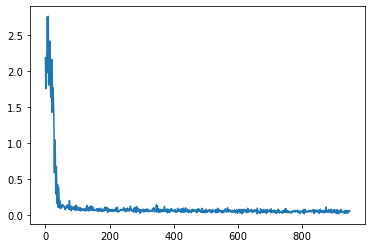

In [29]:
plt.plot(loss_trace)